### На базе простого ResNet покажем влияние инициализации на 
### - точность и скорость обучения
### - распределение весов в слоях


In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import os
import blosc
import simplejson

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.layers import xavier_initializer_conv2d
from scipy.interpolate import spline

sys.path.append("..")
    
from dataset import DatasetIndex, Dataset
from dataset import Batch, action, model, inbatch_parallel
from resnet_batch import MnistBatch
from resnet_batch import draw_stats

### Загрузим данные:

In [3]:
src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

# LEN_MNIST = 65000
# indy = DatasetIndex(np.arange(LEN_MNIST))

# mnistset = Dataset(indy, batch_class=MnistBatch)
# mnistset.cv_split([0.9, 0.1])

ix = DatasetIndex(range(58500))
train_dataset = Dataset(ix, MnistBatch)


In [4]:
n_iterations = 400

In [5]:
convs_inits = [tf.contrib.layers.xavier_initializer(), tf.contrib.layers.xavier_initializer(uniform=False), \
               tf.contrib.layers.variance_scaling_initializer(factor=2.0), tf.truncated_normal_initializer(0.0, 0.01)]
dense_inits = [tf.contrib.layers.xavier_initializer(), tf.contrib.layers.xavier_initializer(uniform=False), \
               tf.contrib.layers.variance_scaling_initializer(factor=2.0), tf.truncated_normal_initializer(0.0, 0.01)]

### Обучим сеть с различными типами инициализации:

- Дефолтный xavier с равномерным распределением tf.contrib.layers.xavier_initializer()
      std = sqrt(6. / (in + out))
- Хavier с нормальным распределением tf.contrib.layers.xavier_initializer(uniform=False)
      std = sqrt(2. / (in + out))
- Почти xavier c кастомным множителем (factor)в числителе std tf.contrib.layers.variance_scaling_initializer(factor=2.0):
      stddev=sqrt(factor / in))
- Для сравнения инициализация просто рандомными числами с потолка взятым std:
      tf.truncated_normal_initializer(0.0, 0.01)


In [25]:
f_stats = open('init_stats.txt', 'w')
f_loss = open('init_loss.txt', 'w')
pipelines = []

for i in range(4):
    config = {'resnet':{'conv_initializer':convs_inits[i], 'dense_initializer':dense_inits[i]}}
    stats = []
    loss_history = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500]))
    print('current config', config)
    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
    pipelines.append(ppl)
    
    f_stats.write('\t'.join(map(str, stats)))
    f_stats.write('\n')
    
    f_loss.write('\t'.join(map(str, loss_history)))
    f_loss.write('\n')

current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000188032152F0>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000188032C4158>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:54<00:00,  7.55it/s]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000001880328BD08>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000188032C42F0>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:53<00:00,  7.60it/s]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000188032B4EA0>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000188032C4378>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:54<00:00,  7.59it/s]


current config {'resnet': {'conv_initializer': <tensorflow.python.ops.init_ops.TruncatedNormal object at 0x00000188034B6278>, 'dense_initializer': <tensorflow.python.ops.init_ops.TruncatedNormal object at 0x00000188034B6240>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:54<00:00,  7.60it/s]


In [26]:
f_loss.close()
f_stats.close()

with open('init_stats.txt', 'r') as f_1:
    stats = []
    for i in f_1.read().splitlines():
        stats.append(i.split('\t'))

with open('init_loss.txt', 'r') as f_2:
    loss_history = []
    for i in f_2.read().splitlines():
        loss_history.append(i.split('\t'))

### Посмотрим на лосс и точность классификации в зависимости от инициализации:

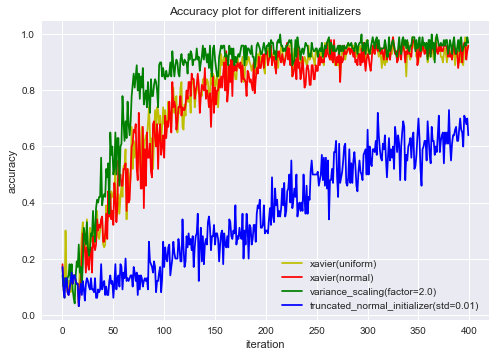

In [27]:
plt.title('Accuracy plot for different initializers')
cols = ['y', 'r', 'g', 'b' ]
inits = ['xavier(uniform)', 'xavier(normal)', \
              'variance_scaling(factor=2.0)', 'truncated_normal_initializer(std=0.01)']

for i, current in enumerate(stats):
    plt.plot(current, c=cols[i], label = inits[i])
    
plt.legend()
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

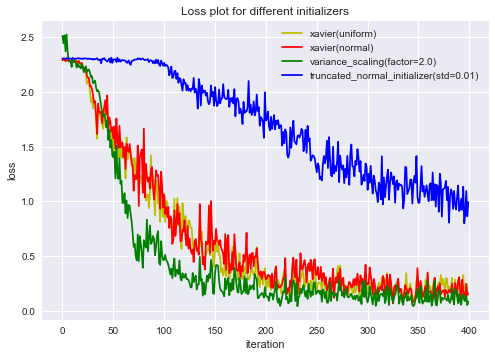

In [28]:
plt.title('Loss plot for different initializers')
cols = ['y', 'r', 'g', 'b']
for i, current in enumerate(loss_history):
    plt.plot(loss_history[i],c=cols[i], label=inits[i])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

### Мы убеждаемся, что инициализации рандомными числами, не подстроенными под размер слоя (tf.truncated_normal_initializer(0.0, 0.01)) работает очень плохо.
### При этом Xavier c большим множителем ( tf.contrib.layers.variance_scaling_initializer(factor=2.0)) стабильно (от запуска к запуску) работает лучше. Что говорит о том, что, возможно, константу лучше подбирать под конкретную задачу, нежели использовать подобранную в какой-то статье под какую-то другую задачу. 

In [30]:
all_sess = []
all_nets = []
for current_ppl in pipelines:
    sess = current_ppl.get_model_by_name('resnet')[-1][-1]
    variables = sess.graph.get_collection('trainable_variables')
    all_sess.append(sess)
    all_nets.append(variables)

### Чтобы убедиться, какой способ инициализации работает лучше в нашем случае, посмотрим на распределения весов по слоям. (Здесь по строкам - слои, по столбцам - способ инициализации, на одном рисунке масштаб по оси x одинаковый)

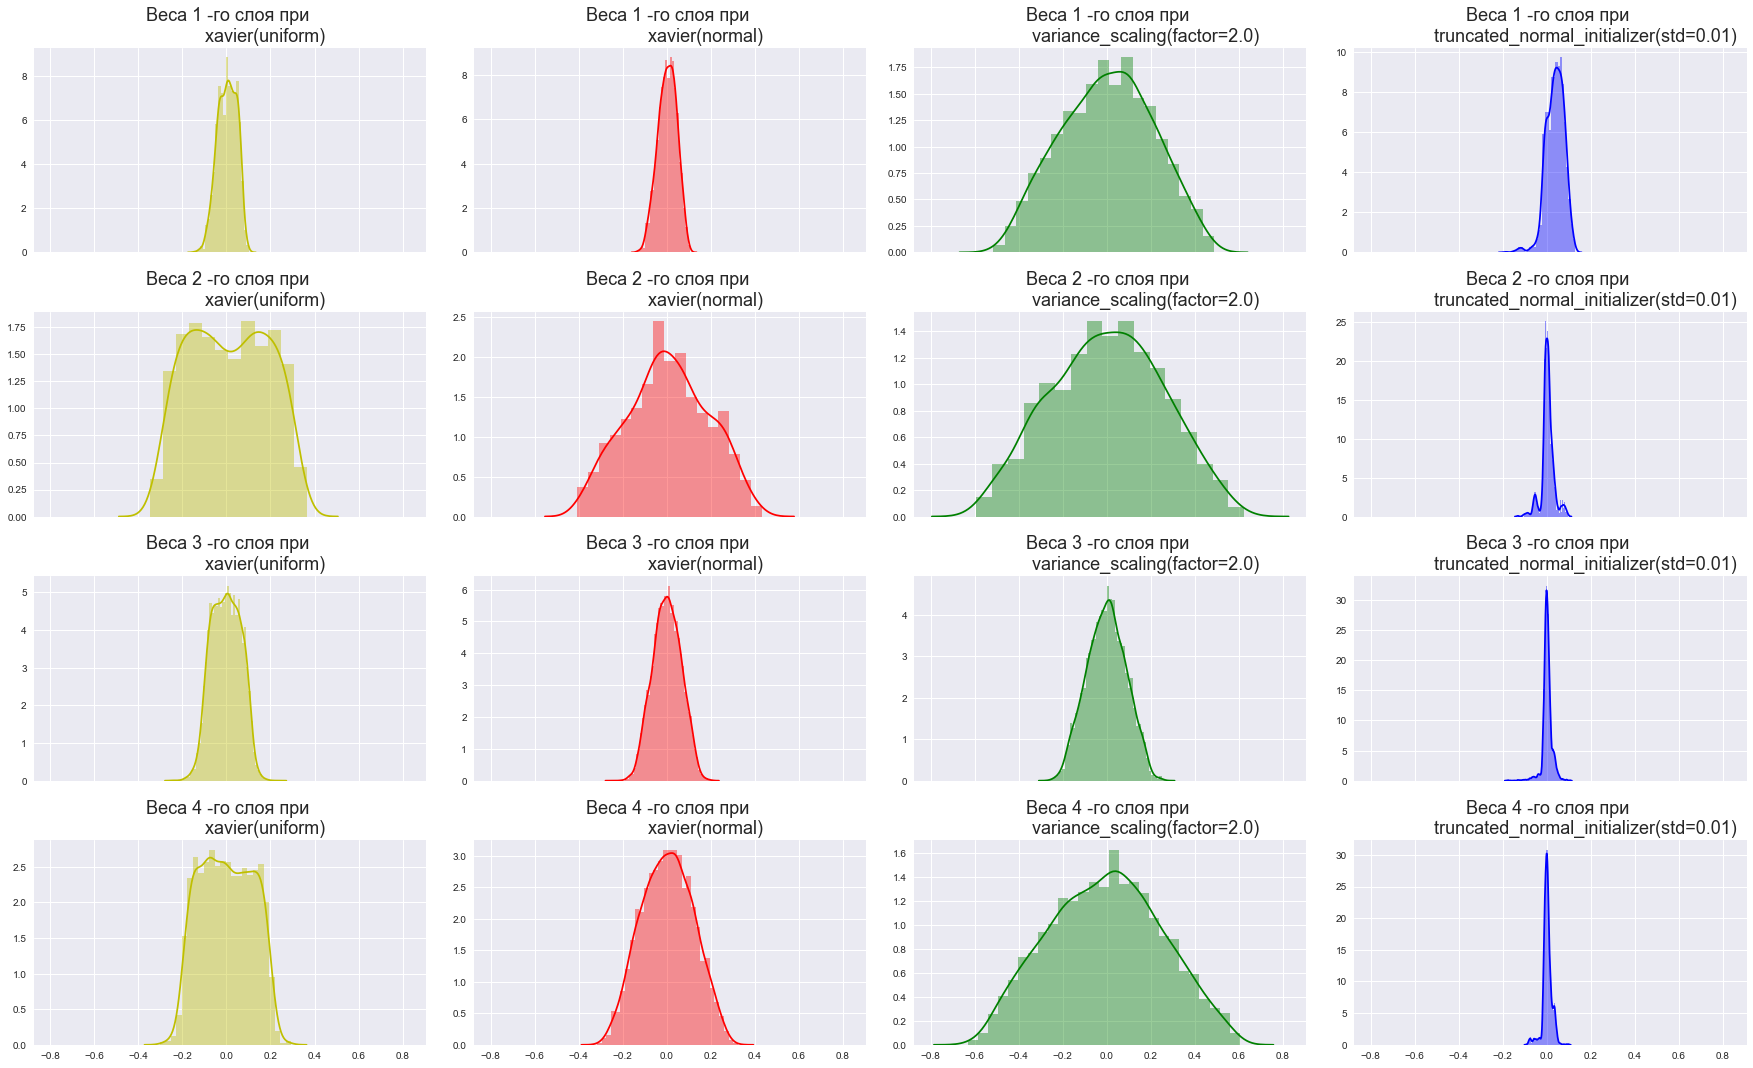

In [68]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(25, 15))
for i, net in enumerate(all_nets):
    for j, layer in enumerate(net[0::2]):
        if j > 3:
            break
        axes[j, i].set_title('Веса {} -го слоя при \n \
             {}'.format(j+1, inits[i]), fontsize=18)
        current = all_sess[i].run(layer)
        current = (np.reshape(current, -1))
        sns.distplot(current, color=cols[i], ax=axes[j, i])

plt.tight_layout()
plt.show()

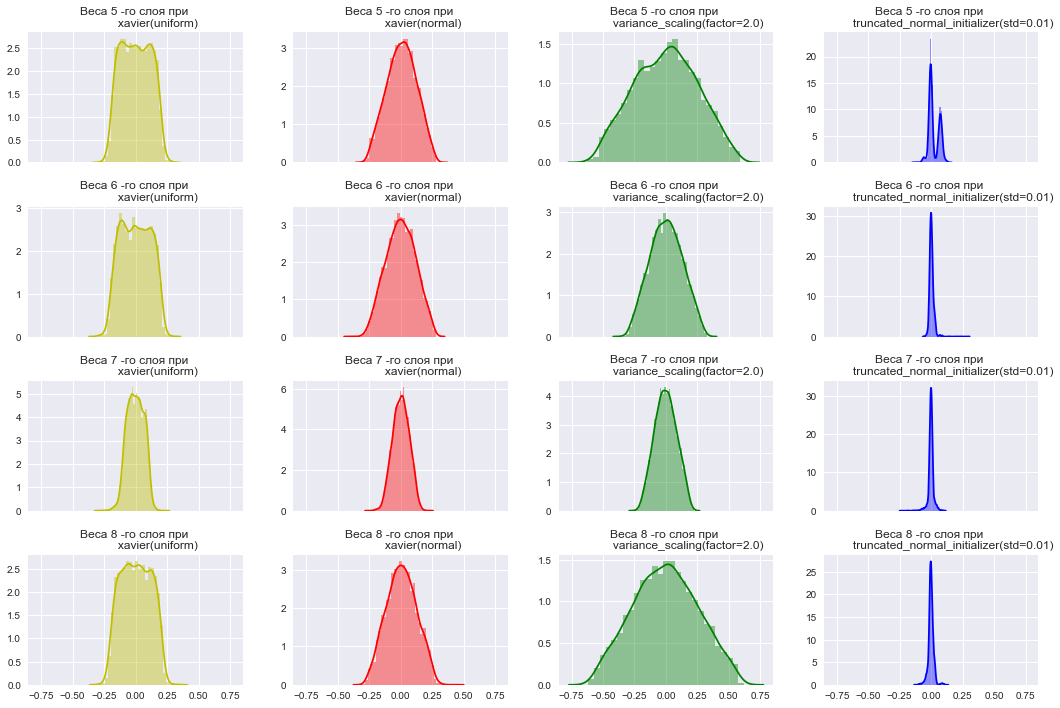

In [72]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(15, 10))
for i, net in enumerate(all_nets):
    for j, layer in enumerate(net[0::2]):
        if j <= 3 or j > 7:
            continue
        axes[j % 4, i  % 4].set_title('Веса {} -го слоя при \n \
            {}'.format(j+1, inits[i]), fontsize=12)
        current = all_sess[i].run(layer)
        current = (np.reshape(current, -1))
        sns.distplot(current, color=cols[i], ax=axes[j % 4, i  % 4])
plt.tight_layout()
plt.show()

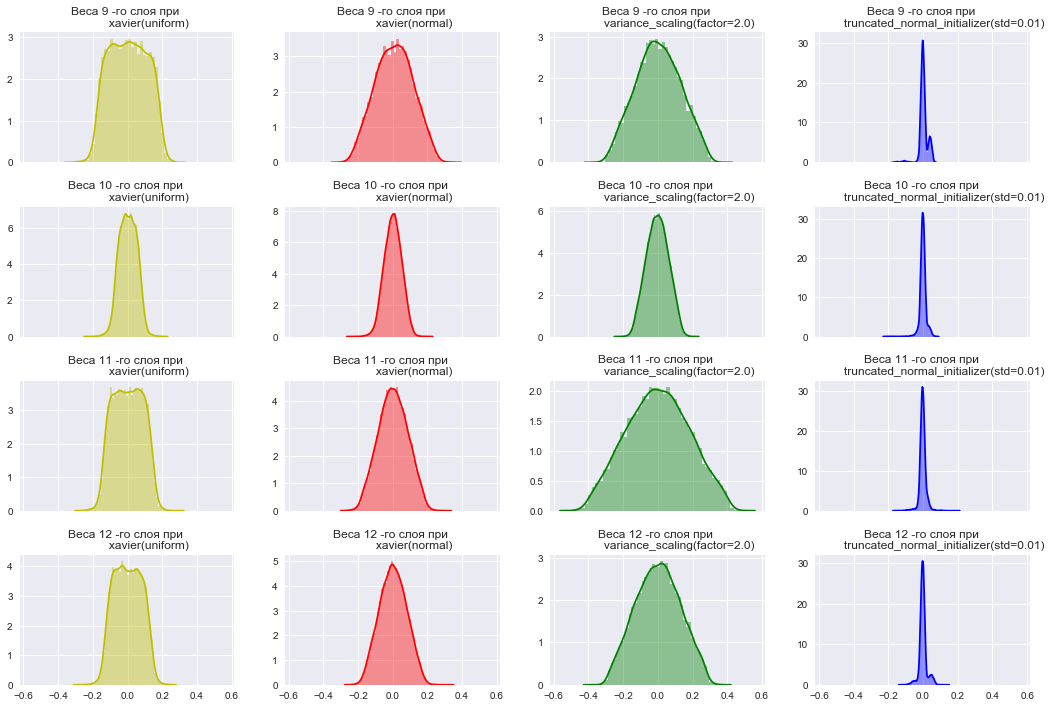

In [73]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(15, 10))
for i, net in enumerate(all_nets):
    for j, layer in enumerate(net[0::2]):
        if j <= 7 or j > 11:
            continue
        axes[j % 4, i  % 4].set_title('Веса {} -го слоя при \n \
            {}'.format(j+1, inits[i]), fontsize=12)
        current = all_sess[i].run(layer)
        current = (np.reshape(current, -1))
        sns.distplot(current, color=cols[i], ax=axes[j % 4, i  % 4])
plt.tight_layout()
plt.show()

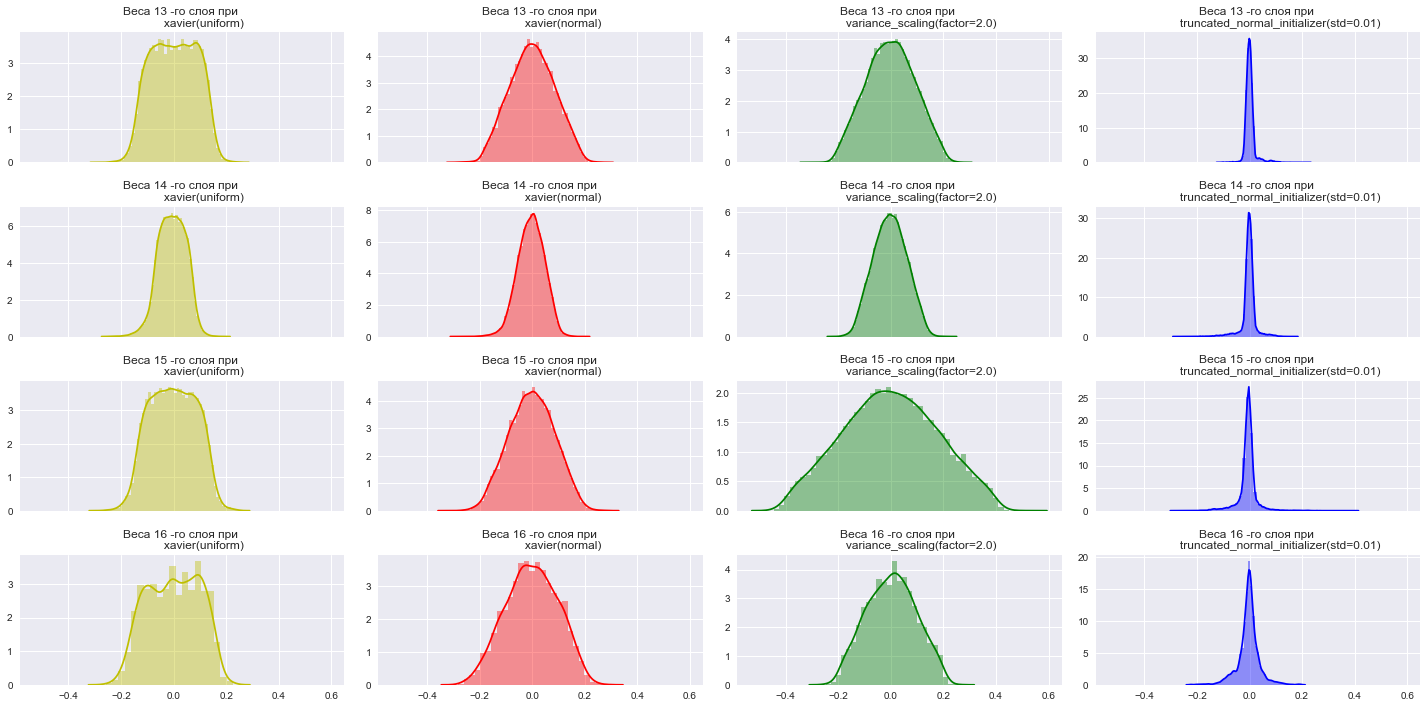

In [74]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(20, 10))
for i, net in enumerate(all_nets):
    for j, layer in enumerate(net[0::2]):
        if j <= 11:
            continue
        axes[j % 4, i  % 4].set_title('Веса {} -го слоя при \n \
            {}'.format(j+1, inits[i]), fontsize=12)

        current = all_sess[i].run(layer)
        current = (np.reshape(current, -1))
        sns.distplot(current, color=cols[i], ax=axes[j % 4, i  % 4])
plt.tight_layout()
plt.show()

### БОльшая (по сравнению с другими) дисперсия весов при инициализации variance_scaling(factor=2.0) говорит о большем количестве различных значений весов и, следовательно, большей значимости каждого веса. 
### В то время как подавляющее большинство близких к друг другу значений при последней инициализации, не подстроенной под размер сети, т.е. не сохраняющей дисперсию приходящих на слой данных, говорит об обратном: небольшое разнообразие весов не позволило добиться сравнимого качества классификации.

### Таким образом, в нашем случае инициализация дефолтной variance_scaling(factor=2.0) работает заметно лучше нормального и равномерного xavier.
### Рассмотрим другие комбинации входных параметров variance_scaling:
    - factor
    - mode
    - uniform

In [79]:
convs_inits = [tf.contrib.layers.variance_scaling_initializer(factor=2.0), tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_AVG'), \
               tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_AVG', uniform=True), tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_OUT', uniform=True)]
dense_inits = convs_inits

f_stats = open('init_stats.txt', 'w')
f_loss = open('init_loss.txt', 'w')
pipelines_inits = []

for i in range(4):
    config = {'resnet':{'conv_initializer':convs_inits[i], 'dense_initializer':dense_inits[i]}}
    stats = []
    loss_history = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500]))
    print('current config', config)
    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
    pipelines_inits.append(ppl)
    
    f_stats.write('\t'.join(map(str, stats)))
    f_stats.write('\n')
    
    f_loss.write('\t'.join(map(str, loss_history)))
    f_loss.write('\n')

current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000001891F3BCAE8>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000001891F3BCAE8>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:52<00:00,  7.97it/s]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000001891F3BCC80>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000001891F3BCC80>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:52<00:00,  7.90it/s]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000001891F3BC048>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x000001891F3BC048>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:51<00:00,  7.91it/s]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x0000018927BB0B70>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x0000018927BB0B70>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:51<00:00,  7.96it/s]


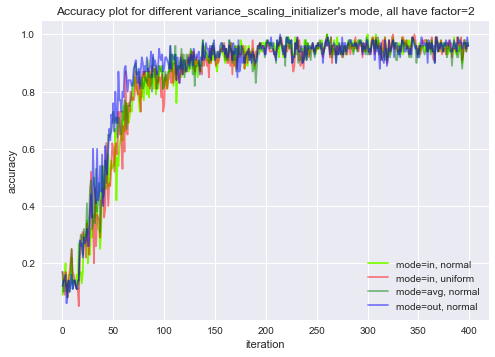

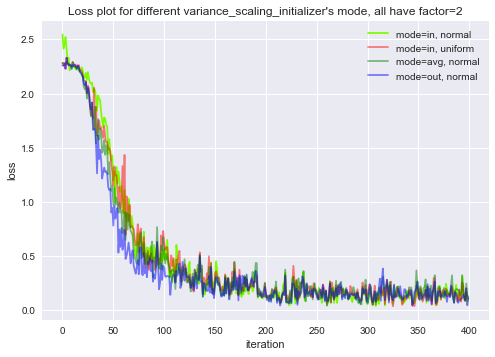

In [115]:
f_loss.close()
f_stats.close()

f_1 = open('init_stats.txt', 'r')
stats = []
for i in f_1.read().splitlines():
    stats.append(i.split('\t'))

f_1.close()

with open('init_loss.txt', 'r') as f_2:
    loss_history = []
    for i in f_2.read().splitlines():
        loss_history.append(i.split('\t'))
        
plt.title('Accuracy plot for different variance_scaling_initializer\'s mode, all have factor=2')
cols = ['lawngreen', 'r', 'g', 'b' ]
mode_inits = ['mode=in, normal', 'mode=in, uniform', 'mode=avg, normal', 'mode=out, normal']
for i, current in enumerate(stats):
    if i == 0:
        plt.plot(current, c=cols[i], label=mode_inits[i], alpha = 1.0)
    else:
        plt.plot(current, c=cols[i], label=mode_inits[i], alpha = 0.5)

plt.legend()
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

plt.title('Loss plot for different variance_scaling_initializer\'s mode, all have factor=2')
for i, current in enumerate(loss_history):
    plt.xlabel('iteration')
    plt.ylabel('loss')
    if i == 0:
        plt.plot(loss_history[i],  c=cols[i], label=mode_inits[i], alpha=0.99)
    else:
        plt.plot(loss_history[i],  c=cols[i], label=mode_inits[i], alpha=0.5)

plt.legend()
plt.show()

### Здесь нет заметнго отрыва, но, похоже, что инициализация с весами, отнормированными на число выходных нейронов, сходится чуть быстрее.

In [87]:
all_sess = []
all_nets = []
for current_ppl in pipelines_inits:
    sess = current_ppl.get_model_by_name('resnet')[-1][-1]
    variables = sess.graph.get_collection('trainable_variables')
    all_sess.append(sess)
    all_nets.append(variables)

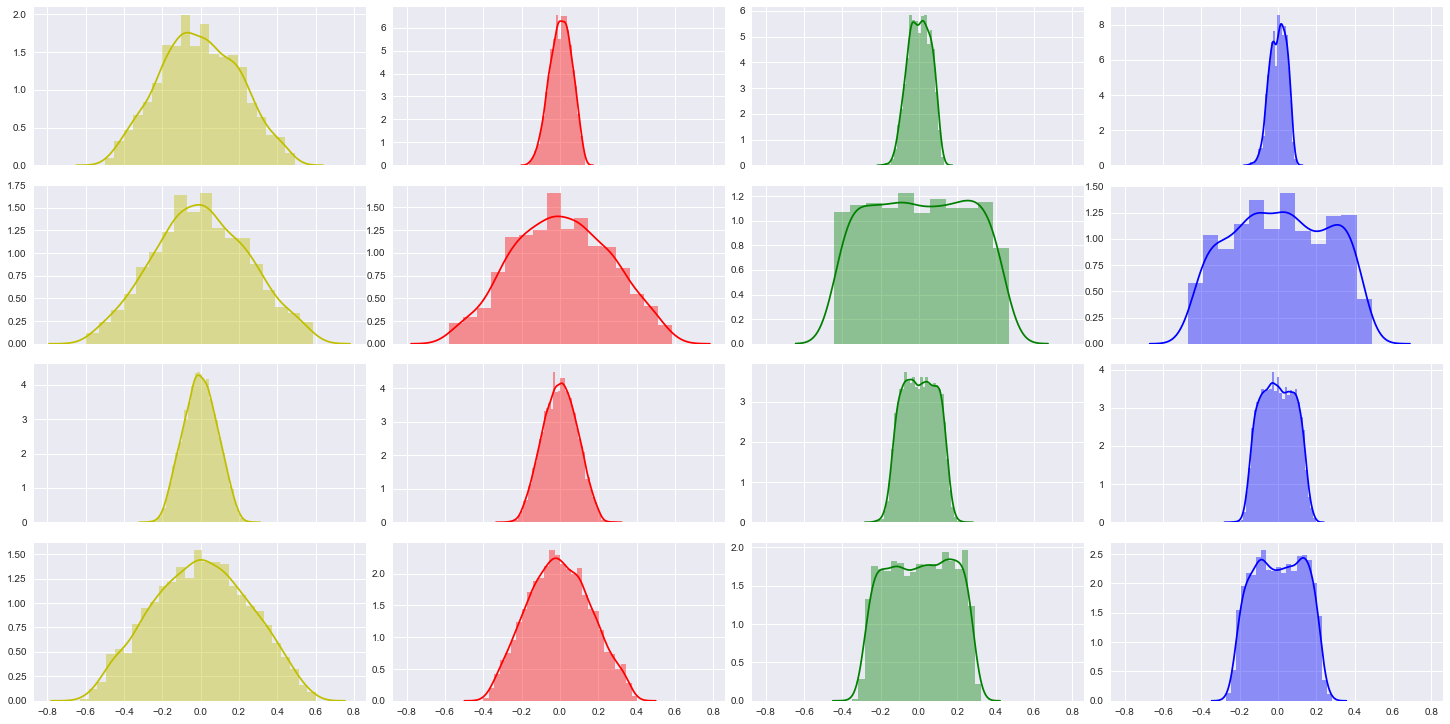

In [88]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(20, 10))
for i, net in enumerate(all_nets):
    for j, layer in enumerate(net[0::2]):
        if j > 3:
            break
        current = all_sess[i].run(layer)
        current = (np.reshape(current, -1))
        sns.distplot(current, color=cols[i], ax=axes[j, i])
#         axes[i].hist(current)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

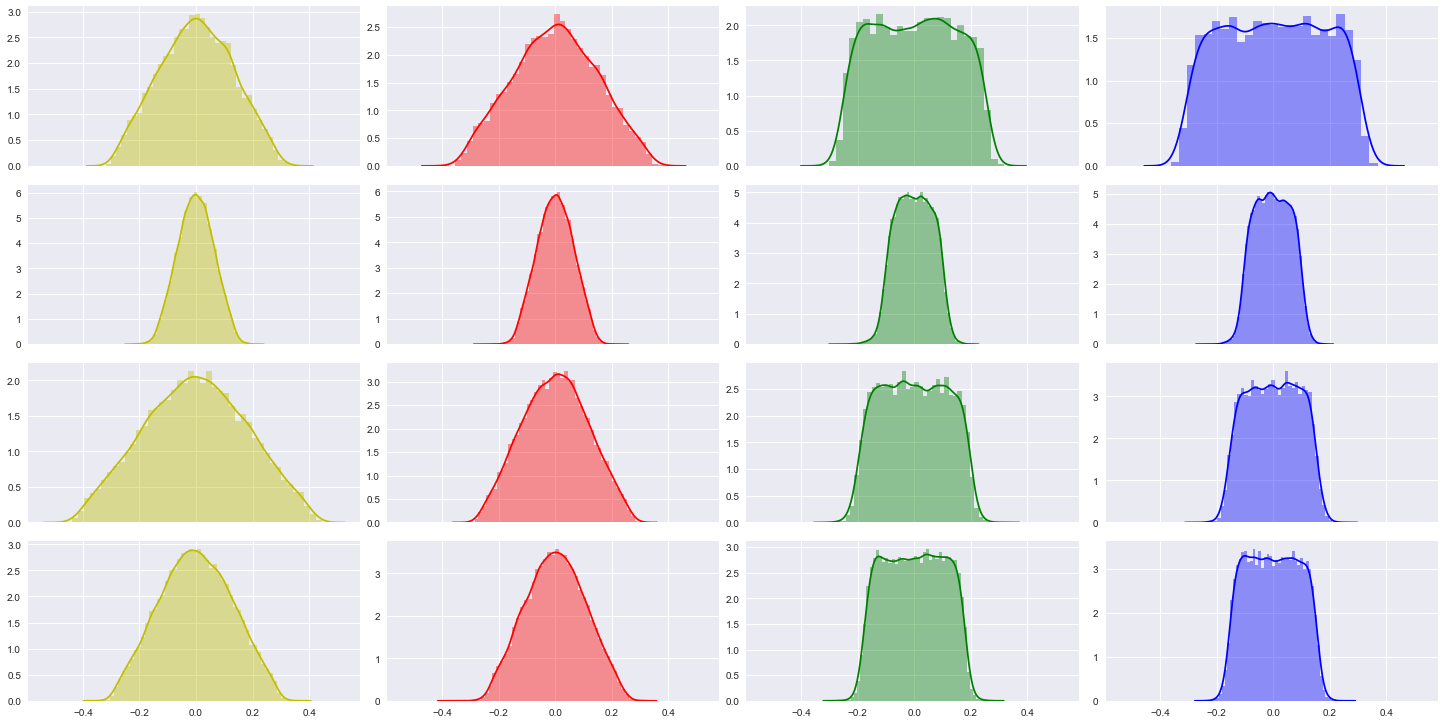

In [89]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(20, 10))
for i, net in enumerate(all_nets):
    for j, layer in enumerate(net[0::2]):
        if j <= 7 or j > 11:
            continue
        current = all_sess[i].run(layer)
        current = (np.reshape(current, -1))
        sns.distplot(current, color=cols[i], ax=axes[j % 4, i  % 4])
#         axes[i].hist(current)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

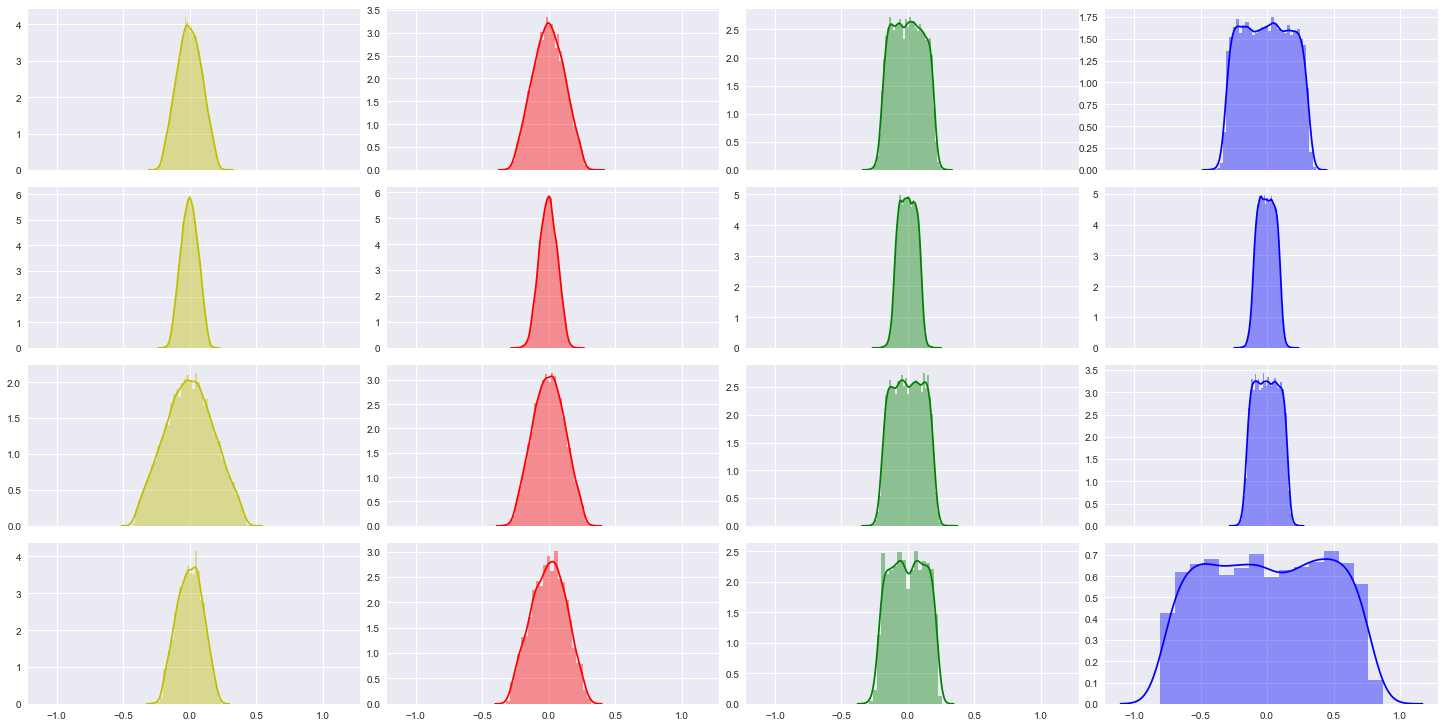

In [93]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(20, 10))
for i, net in enumerate(all_nets):
    for j, layer in enumerate(net[0::2]):
        current = all_sess[i].run(layer)
        if j <= 11:
            continue
        current = (np.reshape(current, -1))
        sns.distplot(current, color=cols[i], ax=axes[j % 4, i  % 4])
#         axes[i].hist(current)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

### Распределение весов также не очень разнятся, кроме весов последнего полносвязного слоя сети (синие графики) с mode=FAN_OUT, обладающих заметно большей дисперсией.
### В то время как инициализация с mode=FAN_IN имеет большую дисперсию на более ранних слоях, особенно заметно это на первом  слое. 

## Рассмотрим влияние константы в числителе variance_scaling_initializer: 

In [15]:
convs_inits = [tf.contrib.layers.variance_scaling_initializer(factor=0.5), tf.contrib.layers.variance_scaling_initializer(factor=1.0), tf.contrib.layers.variance_scaling_initializer(factor=2.0), tf.contrib.layers.variance_scaling_initializer(factor=3.0), \
               tf.contrib.layers.variance_scaling_initializer(factor=4.0), tf.contrib.layers.variance_scaling_initializer(factor=5.0)]
dense_inits = convs_inits

f_stats = open('init_stats.txt', 'w')
f_loss = open('init_loss.txt', 'w')
pipelines = []

for i in range(6):
    config = {'resnet':{'conv_initializer':convs_inits[i], 'dense_initializer':dense_inits[i]}}
    stats = []
    loss_history = []

    ppl = (train_dataset.pipeline(config=config).
       train_res(loss_history, stats, src[0][:58500], full_labs[:58500]))
    print('current config', config)
    for i in tqdm(range(n_iterations)):
        ppl.next_batch(100, n_epochs=None, shuffle=2)
    pipelines.append(ppl)
    
    f_stats.write('\t'.join(map(str, stats)))
    f_stats.write('\n')
    
    f_loss.write('\t'.join(map(str, loss_history)))
    f_loss.write('\n')

current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000222B5EEB510>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000222B5EEB510>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.40it/s]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000222B5EEBC80>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000222B5EEBC80>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.40it/s]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000222B5EEBA60>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000222B5EEBA60>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.39it/s]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000222B5EEB378>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000222B5EEB378>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:32<00:00,  4.29it/s]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000222B5EEB840>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000222B5EEB840>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.42it/s]


current config {'resnet': {'conv_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000222B5EEBB70>, 'dense_initializer': <function variance_scaling_initializer.<locals>._initializer at 0x00000222B5EEBB70>}}


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.46it/s]


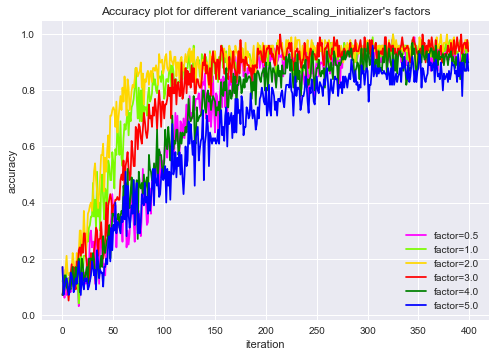

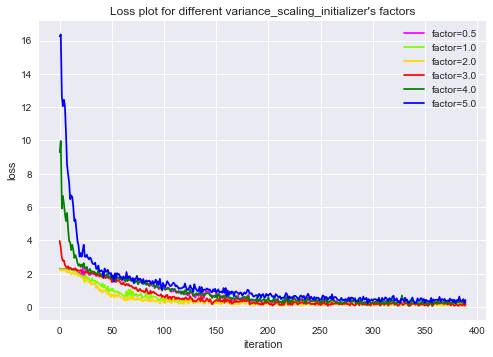

In [23]:
f_loss.close()
f_stats.close()

f_1 = open('init_stats.txt', 'r')
stats = []
for i in f_1.read().splitlines():
    stats.append(i.split('\t'))

f_1.close()

with open('init_loss.txt', 'r') as f_2:
    loss_history = []
    for i in f_2.read().splitlines():
        loss_history.append(i.split('\t'))

factors_inits = ['factor=0.5', 'factor=1.0', 'factor=2.0', 'factor=3.0', 'factor=4.0', 'factor=5.0']
plt.title('Accuracy plot for different variance_scaling_initializer\'s factors')
cols = ['fuchsia', 'lawngreen', 'gold', 'r', 'g', 'b']
for i, current in enumerate(stats):
    plt.plot(current, c=cols[i], label=factors_inits[i])

plt.legend()
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

plt.title('Loss plot for different variance_scaling_initializer\'s factors')
for i, current in enumerate(loss_history):
    plt.xlabel('iteration')
    plt.ylabel('loss')

    plt.plot(loss_history[i][10:],c=cols[i], label=factors_inits[i])
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

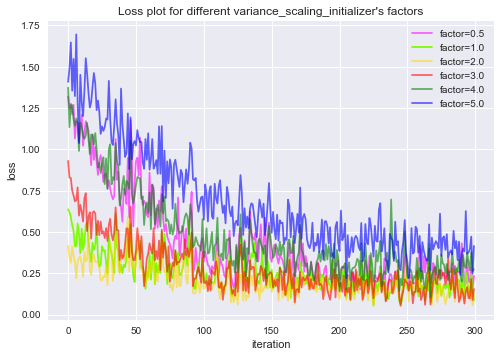

In [28]:
plt.title('Loss plot for different variance_scaling_initializer\'s factors')
for i, current in enumerate(loss_history):
    plt.xlabel('iteration')
    plt.ylabel('loss')
    if i == 1:
        plt.plot(loss_history[i][100:],c=cols[i], label=factors_inits[i], alpha=0.99)
    else:
        plt.plot(loss_history[i][100:],c=cols[i], label=factors_inits[i], alpha=0.6)

plt.legend()
plt.show()

### Убеждаемся, что быстрее всего сеть сходится с factor=2.0